In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers, models

from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as k

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Deep-learning/final project')

In [ ]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

In [ ]:
def plot_prediction(y_test, y_pred, title, r2, mse, scorr):
  plt.figure(figsize=(8, 8))
  sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
  plt.xlabel('True Values (y_test)')
  plt.ylabel('Predicted Values (y_pred)')
  plt.title(title)
  plt.grid(True)
  plt.figtext(0.75, 0.21, f'MSE: {mse:.3f}', horizontalalignment='left', fontsize=11)
  plt.figtext(0.75, 0.18, f'R\u00B2: {r2:.3f}', horizontalalignment='left', fontsize=11)
  plt.figtext(0.75, 0.15, f'Corr: {scorr:.3f}', horizontalalignment='left', fontsize=11)
  plt.show()

In [ ]:
wt = pd.read_csv('WT/WT.csv')
wt.head()

,sgRNA,indel
0,AAAAAAAAACTCCAAAACCCTGG,0.168570
1,AAAAAACAACAAGAAGCACAAGG,0.099624
2,AAAAAACACAAGCAAGACCGTGG,0.247750
3,AAAAAACAGATGCCACCTGTGGG,0.141232
4,AAAAAACCCGTAGATAGCCTCGG,0.045803


In [ ]:
len(wt)

55603

In [ ]:
sgRNA_split = wt['sgRNA'].apply(lambda x: list(x))
sgRNA_split = pd.DataFrame(sgRNA_split.tolist())
sgRNA_split.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,A,A,A,A,A,A,A,A,A,C,...,A,A,A,A,C,C,C,T,G,G
1,A,A,A,A,A,A,C,A,A,C,...,A,A,G,C,A,C,A,A,G,G
2,A,A,A,A,A,A,C,A,C,A,...,A,A,G,A,C,C,G,T,G,G
3,A,A,A,A,A,A,C,A,G,A,...,C,A,C,C,T,G,T,G,G,G
4,A,A,A,A,A,A,C,C,C,G,...,A,T,A,G,C,C,T,C,G,G


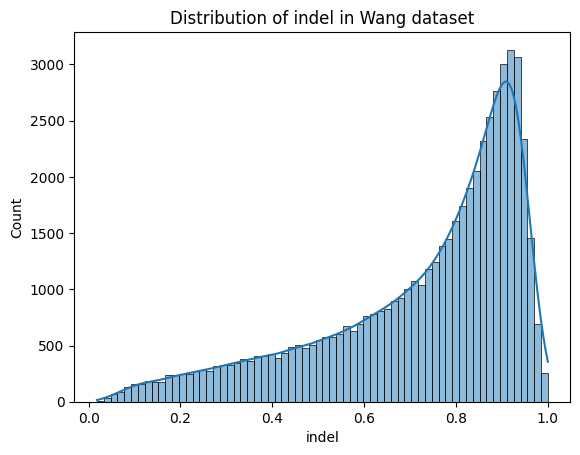

In [ ]:
sns.histplot(wt['indel'], kde=True)
plt.title('Distribution of indel in Wang dataset')
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

sgRNA_split_encoded = sgRNA_split.copy()
label_encoders = {}

for col in sgRNA_split_encoded.columns:
    le = LabelEncoder()
    sgRNA_split_encoded[col] = le.fit_transform(sgRNA_split_encoded[col])
    label_encoders[col] = le

sgRNA_split_encoded = sgRNA_split_encoded.iloc[:, :-2] # Exclude the last two columns
sgRNA_split_encoded.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0,0,0,0,0,0,0,0,0,1,...,1,1,0,0,0,0,1,1,1,3
1,0,0,0,0,0,0,1,0,0,1,...,0,2,0,0,2,1,0,1,0,0
2,0,0,0,0,0,0,1,0,1,0,...,2,1,0,0,2,0,1,1,2,3
3,0,0,0,0,0,0,1,0,2,0,...,2,1,1,0,1,1,3,2,3,2
4,0,0,0,0,0,0,1,1,1,2,...,0,2,0,3,0,2,1,1,3,1


In [ ]:
sgRNA_label = pd.concat([wt.drop('sgRNA', axis=1), sgRNA_split_encoded], axis=1)
sgRNA_label.head()

,indel,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,20
0,0.168570,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1,1,1,3
1,0.099624,0,0,0,0,0,0,1,0,0,...,0,2,0,0,2,1,0,1,0,0
2,0.247750,0,0,0,0,0,0,1,0,1,...,2,1,0,0,2,0,1,1,2,3
3,0.141232,0,0,0,0,0,0,1,0,2,...,2,1,1,0,1,1,3,2,3,2
4,0.045803,0,0,0,0,0,0,1,1,1,...,0,2,0,3,0,2,1,1,3,1


In [ ]:
from sklearn.model_selection import train_test_split

X = sgRNA_label.drop('indel', axis=1)
y = sgRNA_label['indel']

y_binned = pd.cut(y, bins=10, labels=False, include_lowest=True)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_binned)

y_temp_binned = pd.cut(y_temp, bins=10, labels=False, include_lowest=True)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp_binned)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (44482, 21)
y_train shape: (44482,)
X_val shape: (5560, 21)
y_val shape: (5560,)
X_test shape: (5561, 21)
y_test shape: (5561,)


In [ ]:
X_train_reshaped = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.values.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_reshaped = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f'X_train_reshaped shape: {X_train_reshaped.shape}')
print(f'X_val_reshaped shape: {X_val_reshaped.shape}')
print(f'X_test_reshaped shape: {X_test_reshaped.shape}')

X_train_reshaped shape: (44482, 21, 1)
X_val_reshaped shape: (5560, 21, 1)
X_test_reshaped shape: (5561, 21, 1)


### Model 1: simple RNN

In [ ]:
inputs = tf.keras.Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), dtype="int64")
encoded = layers.CategoryEncoding(num_tokens=4, output_mode="one_hot")(inputs)
x = layers.Bidirectional(layers.SimpleRNN(32))(encoded)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="nadam",
              loss="MSE")

In [ ]:
%%time
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("WT/SRNN.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
]
history=model.fit(X_train_reshaped, y_train, validation_data=(X_val_reshaped, y_val), epochs=200, callbacks=callbacks)

Epoch 1/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - loss: 0.0549 - val_loss: 0.0218
Epoch 2/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.0206 - val_loss: 0.0237
Epoch 3/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.0185 - val_loss: 0.0212
Epoch 4/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.0166 - val_loss: 0.0161
Epoch 5/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - loss: 0.0161 - val_loss: 0.0148
Epoch 6/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.0151 - val_loss: 0.0245
Epoch 7/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0150 - val_loss: 0.0158
Epoch 8/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.0141 - val_loss: 0.0143
Epoch 9/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.0139 - val_loss: 0.0140
Epoch 10/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.0135 - val_loss: 0.0147
Epoch 11/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 0.0133 - val_loss: 0.02

In [ ]:
model = keras.models.load_model("WT/SRNN.keras")
model.evaluate(X_test_reshaped,y_test)

174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0134


0.01282889861613512

In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(loss)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,val_loss
19,0.012,0.014
20,0.012,0.013
21,0.012,0.013
22,0.012,0.019
23,0.012,0.013


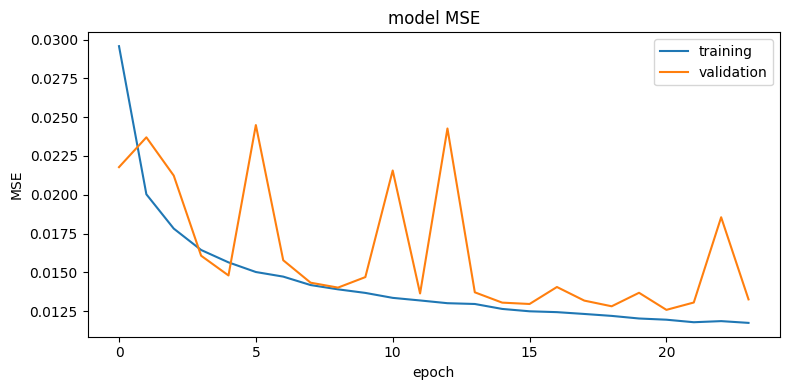

In [ ]:
plt.figure(figsize=(8, 4))
display_training_curves(history_df['loss'], history_df['val_loss'], 'MSE',111)
plt.tight_layout()

174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


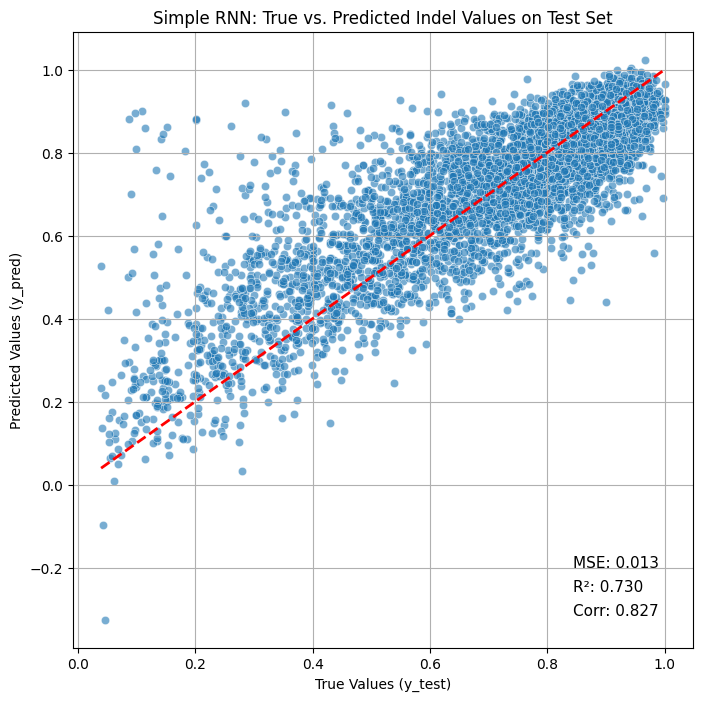

In [ ]:
y_pred = model.predict(X_test_reshaped).flatten()

mse = model.evaluate(X_test_reshaped, y_test, verbose=0)
r2 = r2_score(y_test, y_pred)
scorr = spearmanr(y_test, y_pred).correlation

plot_prediction(y_test, y_pred, title='Simple RNN: True vs. Predicted Indel Values on Test Set', r2=r2, mse=mse,scorr=scorr)

In [ ]:
results_df = pd.DataFrame({'True_Value': y_test, 'Predicted_Value': y_pred}, index=y_test.index)

false_positive_data = results_df[
    (results_df['Predicted_Value'] > 0.6) &
    (results_df['True_Value'] < 0.4)
]

print(f"Number of data points where Predicted Value > 0.6 and True Value < 0.4: {len(false_positive_data)}")
print(false_positive_data.head())

Number of data points where Predicted Value > 0.6 and True Value < 0.4: 73
       True_Value  Predicted_Value
47133    0.393903         0.691247
37780    0.152561         0.862352
8761     0.285496         0.698869
30991    0.372418         0.846919
52291    0.369104         0.770880


### Model 2: bidirectional LSTM

In [ ]:
inputs = tf.keras.Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), dtype="int64")
encoded = layers.CategoryEncoding(num_tokens=4, output_mode="one_hot")(inputs)
x = layers.Bidirectional(layers.LSTM(32))(encoded)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="nadam",
              loss="MSE")

In [ ]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 21, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ category_encoding_3             │ (None, 21, 4)          │             0 │
│ (CategoryEncoding)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,094 (160.53 KB)

 Trainable params: 13,697 (53.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 27,397 (107.02 KB)

In [ ]:
%%time
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("WT/LSTM_32u_bi.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
]
history=model.fit(X_train_reshaped, y_train, validation_data=(X_val_reshaped, y_val), epochs=200, callbacks=callbacks)

Epoch 1/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - loss: 0.0380 - val_loss: 0.0241
Epoch 2/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 0.0234 - val_loss: 0.0209
Epoch 3/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - loss: 0.0202 - val_loss: 0.0639
Epoch 4/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - loss: 0.0180 - val_loss: 0.0203
Epoch 5/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.0159 - val_loss: 0.0153
Epoch 6/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 0.0156 - val_loss: 0.0148
Epoch 7/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 0.0147 - val_loss: 0.0150
Epoch 8/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 0.0142 - val_loss: 0.0140
Epoch 9/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.0142 - val_loss: 0.0145
Epoch 10/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.0137 - val_loss: 0.0132
Epoch 11/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.0134 - val_loss: 0.01

In [ ]:
model = keras.models.load_model("WT/LSTM_32u_bi.keras")
model.evaluate(X_test_reshaped,y_test)

174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0132


0.01294112391769886

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'val_loss'])

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(loss)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,val_loss
12,0.013,0.014
13,0.013,0.012
14,0.012,0.015
15,0.012,0.013
16,0.012,0.013


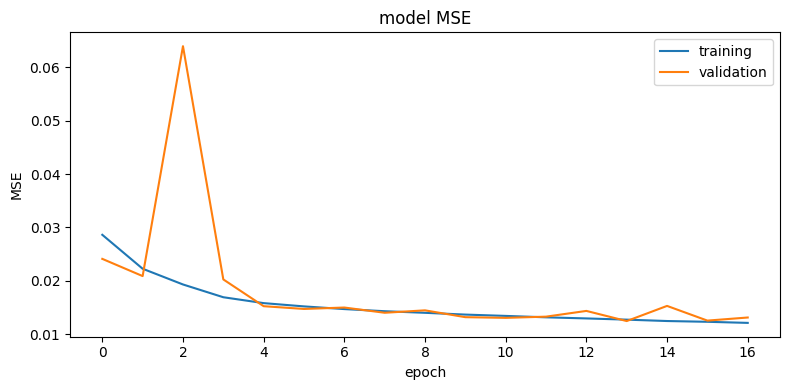

In [ ]:
plt.figure(figsize=(8, 4))
display_training_curves(history_df['loss'], history_df['val_loss'], 'MSE',111)
plt.tight_layout()

174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


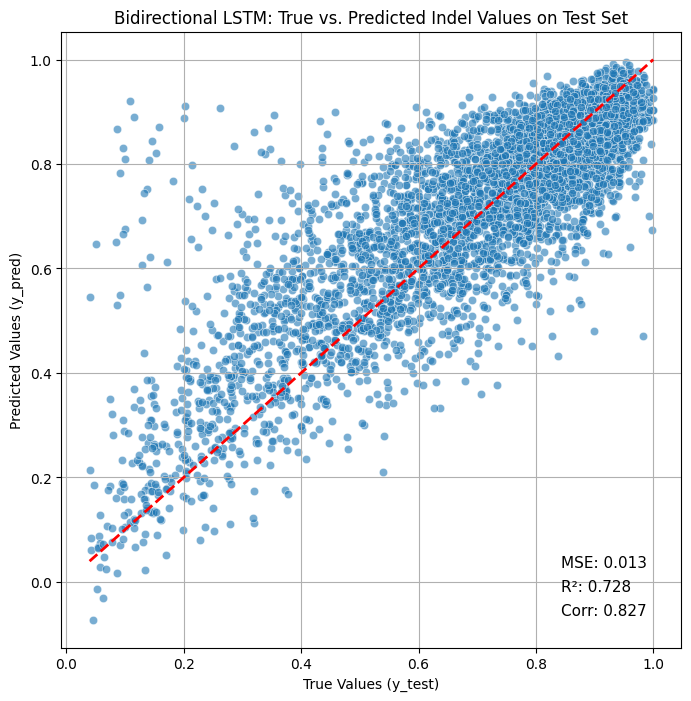

In [ ]:
y_pred_lstm = model.predict(X_test_reshaped).flatten()

mse_lstm = model.evaluate(X_test_reshaped, y_test, verbose=0)
r2_lstm = r2_score(y_test, y_pred_lstm)
scorr_lstm = spearmanr(y_test, y_pred_lstm).correlation

plot_prediction(y_test, y_pred_lstm, title='Bidirectional LSTM: True vs. Predicted Indel Values on Test Set', r2=r2_lstm, mse=mse_lstm, scorr=scorr_lstm)

In [ ]:
results_df = pd.DataFrame({'True_Value': y_test, 'Predicted_Value': y_pred_lstm}, index=y_test.index)

false_positive_data = results_df[
    (results_df['Predicted_Value'] > 0.6) &
    (results_df['True_Value'] < 0.4)
]

print(f"Number of data points where Predicted Value > 0.6 and True Value < 0.4: {len(false_positive_data)}")
print(false_positive_data.head())

Number of data points where Predicted Value > 0.6 and True Value < 0.4: 79
       True_Value  Predicted_Value
47133    0.393903         0.709492
37780    0.152561         0.821615
15762    0.098945         0.674765
30991    0.372418         0.740651
42369    0.201679         0.911095


### Model 3: bidirectional GRU

In [ ]:
inputs = tf.keras.Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), dtype="int64")
encoded = layers.CategoryEncoding(num_tokens=4, output_mode="one_hot")(inputs)
x = layers.Bidirectional(layers.GRU(32))(encoded)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="nadam",
              loss="MSE")

In [ ]:
%%time
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("WT/GRU_32u_bi.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
]
history=model.fit(X_train_reshaped, y_train, validation_data=(X_val_reshaped, y_val), epochs=200, callbacks=callbacks)

Epoch 1/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 36s 23ms/step - loss: 0.0614 - val_loss: 0.0235
Epoch 2/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 31s 23ms/step - loss: 0.0210 - val_loss: 0.0221
Epoch 3/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 36s 26ms/step - loss: 0.0169 - val_loss: 0.0158
Epoch 4/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step - loss: 0.0155 - val_loss: 0.0151
Epoch 5/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - loss: 0.0148 - val_loss: 0.0141
Epoch 6/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step - loss: 0.0144 - val_loss: 0.0144
Epoch 7/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - loss: 0.0139 - val_loss: 0.0135
Epoch 8/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step - loss: 0.0130 - val_loss: 0.0137
Epoch 9/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 32s 23ms/step - loss: 0.0131 - val_loss: 0.0131
Epoch 10/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 11/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - loss: 0.0127 - val_loss: 0.01

In [ ]:
model = keras.models.load_model("WT/GRU_32u_bi.keras")
model.evaluate(X_test_reshaped,y_test)

174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0141


0.013612497597932816

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'val_loss'])

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(loss)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,val_loss
7,0.013,0.014
8,0.013,0.013
9,0.013,0.014
10,0.013,0.013
11,0.012,0.014


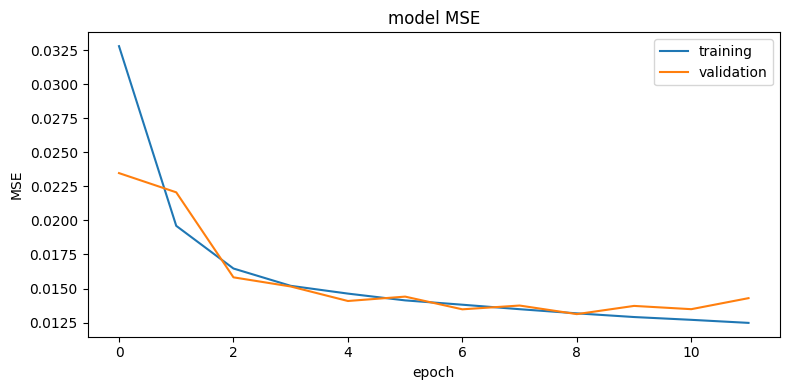

In [ ]:
plt.figure(figsize=(8, 4))
display_training_curves(history_df['loss'], history_df['val_loss'], 'MSE',111)
plt.tight_layout()

174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step


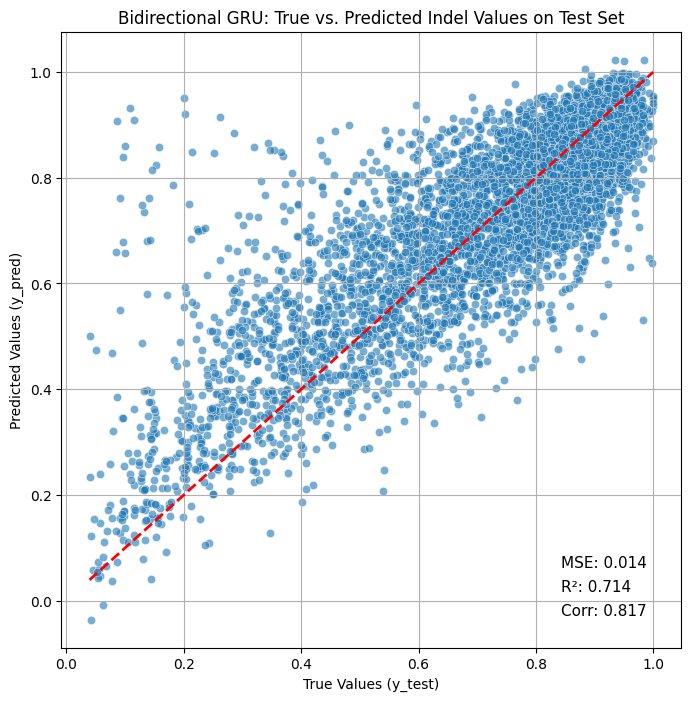

In [ ]:
y_pred_gru = model.predict(X_test_reshaped).flatten()

mse_gru = model.evaluate(X_test_reshaped, y_test, verbose=0)
r2_gru = r2_score(y_test, y_pred_gru)
scorr_gru = spearmanr(y_test, y_pred_gru).correlation

plot_prediction(y_test, y_pred_gru, title='Bidirectional GRU: True vs. Predicted Indel Values on Test Set', r2=r2_gru, mse=mse_gru, scorr=scorr_gru)

In [ ]:
results_df = pd.DataFrame({'True_Value': y_test, 'Predicted_Value': y_pred_gru}, index=y_test.index)

false_positive_data = results_df[
    (results_df['Predicted_Value'] > 0.6) &
    (results_df['True_Value'] < 0.4)
]

print(f"Number of data points where Predicted Value > 0.6 and True Value < 0.4: {len(false_positive_data)}")
print(false_positive_data.head())

Number of data points where Predicted Value > 0.6 and True Value < 0.4: 79
       True_Value  Predicted_Value
47133    0.393903         0.748819
37780    0.152561         0.823219
15762    0.098945         0.657712
30991    0.372418         0.787757
54185    0.360289         0.625560


### Model 4: Bidirectional LSTM with learned embeddings of different dimensions

In [ ]:
inputs = tf.keras.Input(shape=(X_train.shape[1],), dtype="int64")
embedded = layers.Embedding(input_dim=4, output_dim=16)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="nadam",
              loss="MSE")
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 21, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,425 (29.00 KB)

 Trainable params: 7,425 (29.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%%time
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("WT/LSTM_32u_bi_embed16.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
]
history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, callbacks=callbacks)

Epoch 1/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - loss: 0.0411 - val_loss: 0.0238
Epoch 2/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.0224 - val_loss: 0.0226
Epoch 3/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 0.0204 - val_loss: 0.0202
Epoch 4/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 0.0192 - val_loss: 0.0211
Epoch 5/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - loss: 0.0177 - val_loss: 0.0169
Epoch 6/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 0.0166 - val_loss: 0.0159
Epoch 7/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.0155 - val_loss: 0.0189
Epoch 8/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - loss: 0.0151 - val_loss: 0.0159
Epoch 9/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0147 - val_loss: 0.0152
Epoch 10/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.0142 - val_loss: 0.0158
Epoch 11/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - loss: 0.0139 - val_loss: 0.01

In [ ]:
model = keras.models.load_model("WT/LSTM_32u_bi_embed16.keras")
model.evaluate(X_test_reshaped,y_test)

174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0136


0.01306845061480999

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'val_loss'])

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(loss)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,val_loss
9,0.013,0.015
10,0.013,0.013
11,0.013,0.016
12,0.012,0.014
13,0.012,0.013


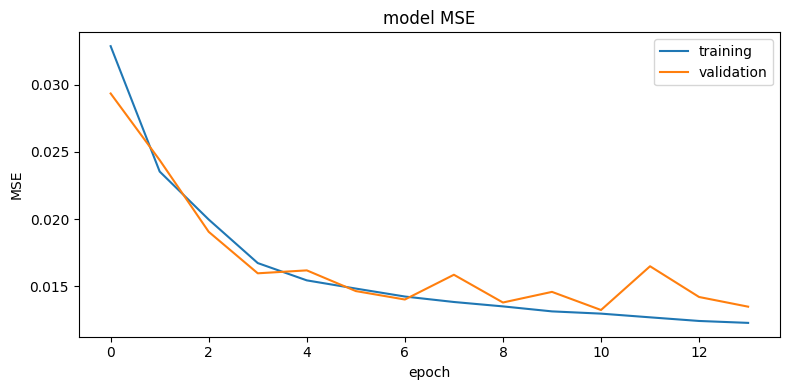

In [ ]:
plt.figure(figsize=(8, 4))
display_training_curves(history_df['loss'], history_df['val_loss'], 'MSE',111)
plt.tight_layout()

174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


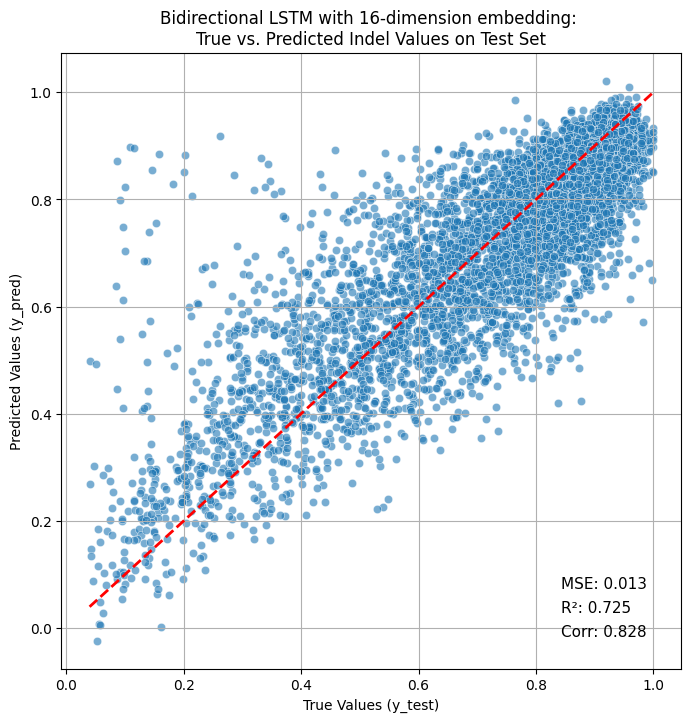

In [ ]:
y_pred_lstm_embed = model.predict(X_test_reshaped).flatten()

mse = model.evaluate(X_test_reshaped, y_test, verbose=0)
r2 = r2_score(y_test, y_pred_lstm_embed)
scorr = spearmanr(y_test, y_pred_lstm_embed).correlation

plot_prediction(y_test, y_pred_lstm_embed, title='Bidirectional LSTM with 16-dimension embedding: \nTrue vs. Predicted Indel Values on Test Set', r2=r2, mse=mse, scorr=scorr)

In [ ]:
results_df = pd.DataFrame({'True_Value': y_test, 'Predicted_Value': y_pred_lstm_embed}, index=y_test.index)

false_positive_data = results_df[
    (results_df['Predicted_Value'] > 0.6) &
    (results_df['True_Value'] < 0.4)
]

print(f"Number of data points where Predicted Value > 0.6 and True Value < 0.4: {len(false_positive_data)}")
print(false_positive_data.head())

Number of data points where Predicted Value > 0.6 and True Value < 0.4: 64
       True_Value  Predicted_Value
37780    0.152561         0.756772
15762    0.098945         0.702952
30991    0.372418         0.766337
52291    0.369104         0.768898
42369    0.201679         0.883720


Inspect the hidden layer outputs of LSTM

In [ ]:
layer_name = 'bidirectional_6'
layer_output = model.get_layer(layer_name).output
intermediate_model = models.Model(
    inputs=model.inputs, outputs=layer_output
)
activations = intermediate_model.predict(X_test_reshaped)

174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [ ]:
activation_data = {}
for k in range(0,64):
    activation_data[f"act_val_{k}"] = activations[:,k]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
act_val_0,0.073,0.209,0.213,0.046,-0.076,0.142,-0.005,0.172,0.099,0.174,0.043,0.060,0.203,-0.017,-0.008
act_val_1,0.000,0.081,0.034,-0.018,-0.099,-0.018,-0.074,0.094,-0.012,0.053,0.028,-0.033,0.079,-0.081,0.019
act_val_2,-0.044,0.097,0.380,0.045,0.089,0.029,-0.064,0.155,0.188,0.092,-0.045,-0.022,0.153,-0.089,0.014
act_val_3,0.051,0.015,0.127,0.144,0.114,0.117,0.139,0.020,0.064,0.130,0.012,0.114,0.025,0.142,0.024
act_val_4,0.422,0.138,0.256,0.237,0.213,0.236,0.337,0.138,0.323,0.269,0.077,0.557,0.134,0.172,0.069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
act_val_59,-0.140,-0.072,0.088,-0.060,0.107,-0.041,-0.106,0.095,-0.038,-0.004,-0.210,-0.154,-0.015,-0.018,-0.305
act_val_60,0.084,-0.058,-0.083,-0.082,-0.144,-0.056,0.169,-0.040,-0.045,-0.115,-0.035,-0.033,-0.053,-0.088,0.022
act_val_61,0.003,-0.008,-0.077,-0.156,-0.121,-0.034,-0.084,-0.122,-0.039,0.049,-0.087,0.039,-0.089,-0.209,-0.024
act_val_62,0.147,0.065,-0.031,0.007,0.084,0.120,0.295,0.028,0.181,-0.153,0.153,0.079,0.041,0.127,-0.112


In [ ]:
from sklearn.manifold import TSNE
import matplotlib as mpl

In [ ]:
%%time
tsne = TSNE(n_components=2
            ,init='pca'
            ,learning_rate='auto'
            ,verbose=0
            ,perplexity=30, max_iter=300)
tsne_results = tsne.fit_transform(activation_df)

CPU times: user 21.9 s, sys: 53.7 ms, total: 21.9 s
Wall time: 30.3 s


In [ ]:
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

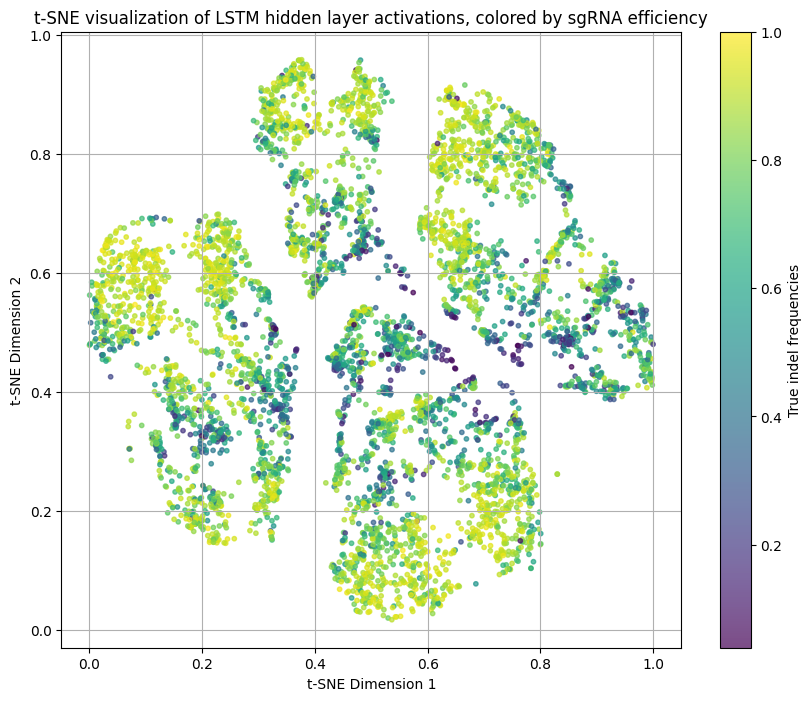

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_test, cmap='viridis', s=10, alpha=0.7)
plt.colorbar(scatter, label='True indel frequencies')
plt.title('t-SNE visualization of LSTM hidden layer activations, colored by sgRNA efficiency')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.show()

In [ ]:
inputs = tf.keras.Input(shape=(X_train.shape[1],), dtype="int64")
embedded = layers.Embedding(input_dim=4, output_dim=64)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="nadam",
              loss="MSE")
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, 21, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,313 (114.50 KB)

 Trainable params: 29,313 (114.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%%time
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("WT/LSTM_32u_bi_embed64.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
]
history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, callbacks=callbacks)

Epoch 1/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 66s 42ms/step - loss: 0.0424 - val_loss: 0.0248
Epoch 2/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 44s 32ms/step - loss: 0.0226 - val_loss: 0.0277
Epoch 3/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 76s 28ms/step - loss: 0.0186 - val_loss: 0.0176
Epoch 4/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - loss: 0.0162 - val_loss: 0.0155
Epoch 5/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 43s 26ms/step - loss: 0.0150 - val_loss: 0.0151
Epoch 6/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 35s 25ms/step - loss: 0.0145 - val_loss: 0.0142
Epoch 7/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 32s 23ms/step - loss: 0.0139 - val_loss: 0.0137
Epoch 8/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - loss: 0.0136 - val_loss: 0.0183
Epoch 9/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - loss: 0.0133 - val_loss: 0.0134
Epoch 10/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 43s 26ms/step - loss: 0.0130 - val_loss: 0.0149
Epoch 11/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 32s 23ms/step - loss: 0.0125 - val_loss: 0.01

In [ ]:
model = keras.models.load_model("WT/LSTM_32u_bi_embed64.keras")
model.evaluate(X_test_reshaped,y_test)

174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0131


0.012662023305892944

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'val_loss'])

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(loss)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,val_loss
11,0.012,0.013
12,0.012,0.013
13,0.012,0.013
14,0.012,0.013
15,0.012,0.013


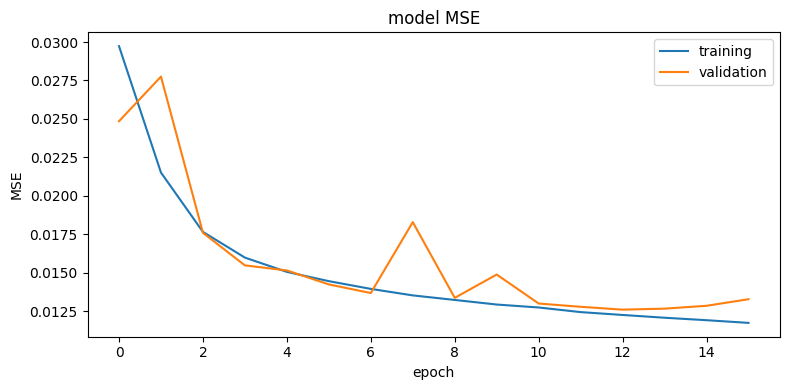

In [ ]:
plt.figure(figsize=(8, 4))
display_training_curves(history_df['loss'], history_df['val_loss'], 'MSE',111)
plt.tight_layout()

174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


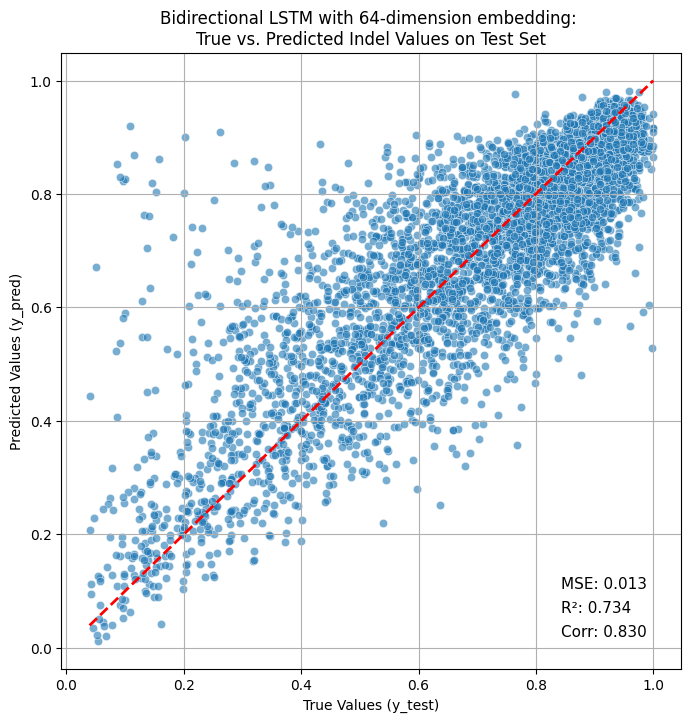

In [ ]:
y_pred_lstm_embed = model.predict(X_test_reshaped).flatten()

mse = model.evaluate(X_test_reshaped, y_test, verbose=0)
r2 = r2_score(y_test, y_pred_lstm_embed)
scorr = spearmanr(y_test, y_pred_lstm_embed).correlation

plot_prediction(y_test, y_pred_lstm_embed, title='Bidirectional LSTM with 64-dimension embedding: \nTrue vs. Predicted Indel Values on Test Set', r2=r2, mse=mse, scorr=scorr)

In [ ]:
results_df = pd.DataFrame({'True_Value': y_test, 'Predicted_Value': y_pred_lstm_embed}, index=y_test.index)

false_positive_data = results_df[
    (results_df['Predicted_Value'] > 0.6) &
    (results_df['True_Value'] < 0.4)
]

print(f"Number of data points where Predicted Value > 0.6 and True Value < 0.4: {len(false_positive_data)}")
print(false_positive_data.head())

Number of data points where Predicted Value > 0.6 and True Value < 0.4: 71
       True_Value  Predicted_Value
47133    0.393903         0.734999
37780    0.152561         0.802998
30991    0.372418         0.641042
52291    0.369104         0.626397
42369    0.201679         0.901141
